In [ ]:
!pip install wordcloud # install wordcloud if needed
!pip install --upgrade s3fs

In [3]:
import pandas as pd
from ast import literal_eval
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# download nltk packages for the first time
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.model_selection import train_test_split
import dask.dataframe as dd


Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Load data using Dask
df = pd.read_csv('fake_job_postings.csv')


In [5]:
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [6]:
df.shape

(17880, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:

# Get the number of books, users, and reviews in the dataset
number_locations = df['location'].nunique()
number_titles = df['title'].nunique()
number_industries = df['industry'].nunique()

In [8]:
print(f'Number of Locations: {number_locations}')
print(f'Number of Job Titles: {number_titles}')
print(f'Number of Industries: {number_industries}')

Number of Locations: 3105
Number of Job Titles: 11231
Number of Industries: 131


In [9]:

# get count on spoilers
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

### Proportion of Spoilers

/tmp/ipykernel_9093/3914530993.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='fraudulent', data=df, palette='hsv')


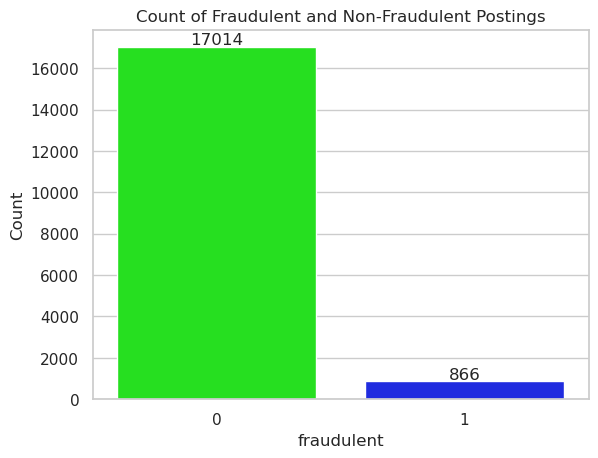

In [10]:
# convert the encoded values into string
df['fradulent_unencoded'] = df['fraudulent'].map({0: 'Not Fraudulent', 1: 'Fraudulent'})

# set the style
sns.set(style="whitegrid")  


# create a bar plot
ax = sns.countplot(x='fraudulent', data=df, palette='hsv')

# annotate each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Set labels and title
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Postings')

# show plot
plt.show()

### Create Wordclouds

In [11]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'fradulent_unencoded'],
      dtype='object')

In [12]:
# merge job description, requirements, and benefits
df['text'] = df['description'].fillna(' ') +''+  df['requirements'].fillna(' ')+ ' ' +df['benefits']

In [13]:
# plot a wordcloud with a given text
def plot_wordcloud(text_series, category):
    # Assuming your text data is in a pandas DataFrame df_spoiler and column name is 'Text'
    text_data = text_series.dropna().str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.title(f'Word Cloud from {category} Postings')
    plt.show()
    

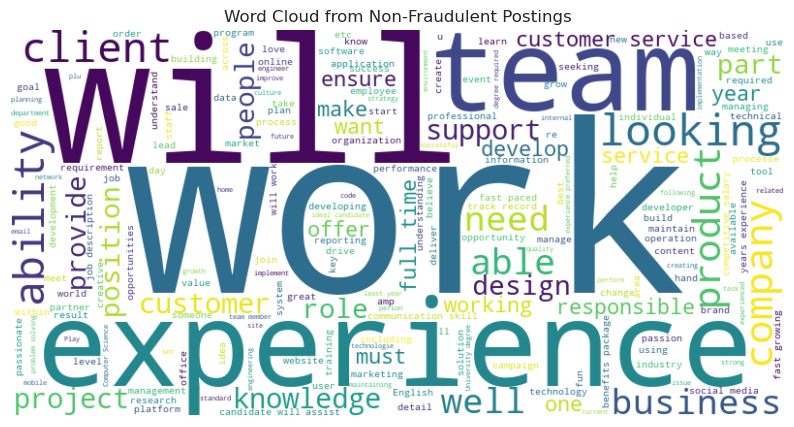

In [14]:
# plot the wordcloud for non-spoiler reviews
text_series_no_fraudulent = df[df['fraudulent']==0]['text']
plot_wordcloud(text_series=text_series_no_fraudulent, category='Non-Fraudulent')

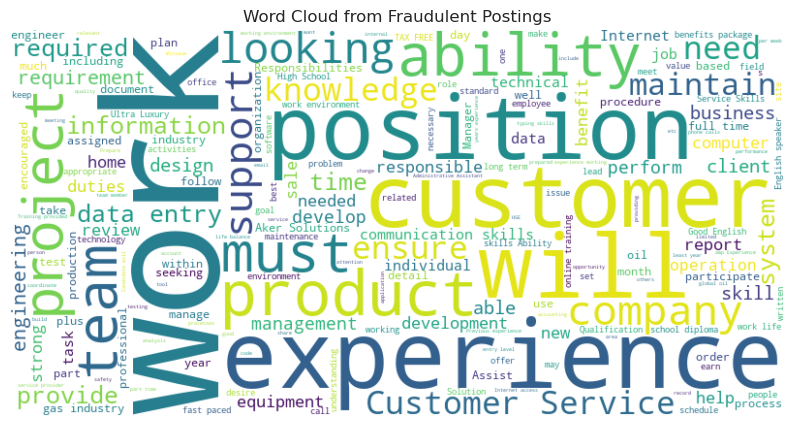

In [15]:
# plot the wordcloud for spoiler reviews

text_series_fraudulent = df[df['fraudulent']==1]['text']
plot_wordcloud(text_series=text_series_fraudulent,category='Fraudulent')

### Evaluating Text Length with Box Plot

In [18]:
df['text']

0                                                      NaN
1        Organised - Focused - Vibrant - Awesome!Do you...
2                                                      NaN
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877                                                  NaN
17878    Nemsia Studios is looking for an experienced v...
17879                                                  NaN
Name: text, Length: 17880, dtype: object

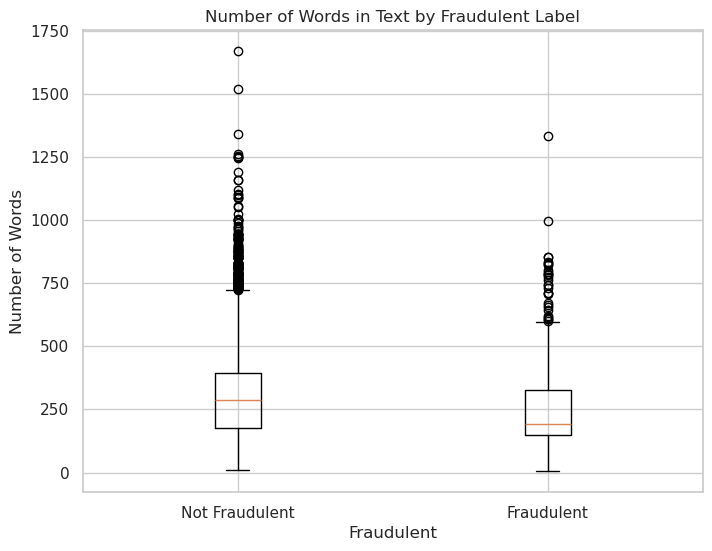

In [21]:
df = df[df['text'].isnull()==False]

# Calculate the number of words in the 'text' column
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Separate the data based on the 'fraudulent' column
fraudulent_0 = df[df['fraudulent'] == 0]['num_words']
fraudulent_1 = df[df['fraudulent'] == 1]['num_words']

# Creating the box plot
plt.figure(figsize=(8, 6))
plt.boxplot([fraudulent_0, fraudulent_1], labels=['Not Fraudulent', 'Fraudulent'])
plt.title('Number of Words in Text by Fraudulent Label')
plt.xlabel('Fraudulent')
plt.ylabel('Number of Words')
plt.grid(True)
plt.show()

### Create Training, Testing, and Validation Sets

In [22]:
df_copy = df.copy(deep=True)
df_copy = df_copy[['text', 'fraudulent']]


In [23]:
df_copy.isnull().sum()

text          0
fraudulent    0
dtype: int64

In [24]:
df_copy.shape

(10668, 2)

In [25]:
# drop null values
df_copy = df_copy.dropna()

In [26]:
# Splitting into train (50%) and temp (50%)
train, temp = train_test_split(df_copy, test_size=0.5, random_state=42, stratify=df_copy['fraudulent'])

# Further splitting temp into test (20%) and validation (30%)
test, validation = train_test_split(temp, test_size=0.4, random_state=42, stratify=temp['fraudulent'])


In [49]:
# export these datasets to s3 as csv files
s3_path = 's3://fake-job-posting-detection/Data'
train.to_csv(f'{s3_path}/train.csv', index=False)
test.to_csv(f'{s3_path}/test.csv', index=False)
validation.to_csv(f'{s3_path}/validation.csv', index=False)

In [27]:
train['fraudulent'].value_counts()

fraudulent
0    5083
1     251
Name: count, dtype: int64